<a href="https://colab.research.google.com/github/Bitszilla/FaceAIModel/blob/main/2_AutismFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Importing Libraries


In [ ]:
import tensorflow as tf
print(len(tf.config.list_physical_devices('GPU')))
import torch
print(torch.cuda.is_available())

1
True


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage import transform

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
photo_size=224 #56, 224

In [ ]:
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale= 1 / 255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=32,
        classes=['non_autistic','autistic'],
        shuffle=False
    )
    return generator

In [ ]:
# dataset is linked here: https://www.kaggle.com/datasets/imrankhan77/autistic-children-facial-data-set
train_data=prepare_dataset('/content/drive/MyDrive/Autism Photos Dataset/train')
validation_data = prepare_dataset('/content/drive/MyDrive/Autism Photos Dataset/valid')
test_data=prepare_dataset('/content/drive/MyDrive/Autism Photos Dataset/test')

Found 2538 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [ ]:
validation_data.class_indices

{'non_autistic': 0, 'autistic': 1}

# VGG Models (VGG16 & VGG19)

In [ ]:
# example of tending the vgg16 model
def create_vgg_model():
    #from keras.applications.vgg16 import VGG16
    from keras.applications.vgg19 import VGG19
    from keras.models import Model
    from keras.layers import Dense
    from keras.layers import Flatten
    # load model without classifier layers
    #model = VGG16(include_top=False, input_shape=(photo_size, photo_size, 3))
    model = VGG19(include_top=False, input_shape=(photo_size, photo_size, 3))
    for layer_idx in range(len(model.layers)):
        if layer_idx not in [1,2,3,15,16,17,18]:
            model.layers[layer_idx].trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(256, activation='relu')(flat1)
    output = Dense(95, activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    return model

In [ ]:
vgg_model=create_vgg_model()
vgg_model.summary()

In [ ]:
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit(
    train_data,
    epochs=100,
    validation_data=validation_data
)
#vgg_model.save("vgg_model50.h5")
vgg_model.save('vgg19_model100.keras')

In [ ]:
vgg_model.evaluate(test_data)

10/10 [==============================] - 3s 327ms/step


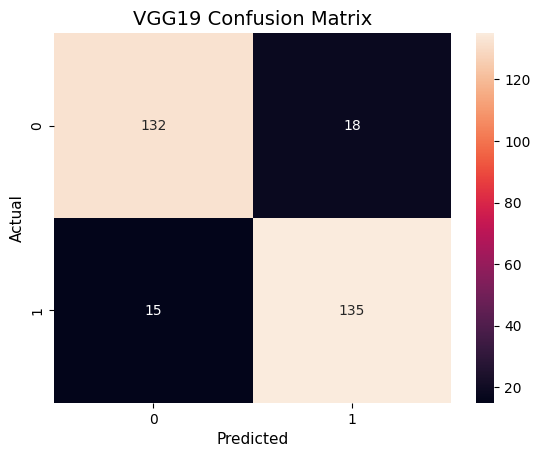

Accuracy (VGG19 [Eph:100]): 0.89
              precision    recall  f1-score   support

non_autistic       0.90      0.88      0.89       150
    autistic       0.88      0.90      0.89       150

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

predictions = vgg_model.predict(test_data, steps = np.math.ceil(test_data.samples / test_data.batch_size),)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

#cm_display = ConfusionMatrixDisplay(cm).plot()

# Plot the confusion matrix.
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual',fontsize=11)
plt.xlabel('Predicted',fontsize=11)
plt.title('VGG19 Confusion Matrix',fontsize=14)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy (VGG19 [Eph:100]):", accuracy)

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# INCEPTION Models (InceptionResNetV2 & InceptionV3)


In [ ]:

def create_inception_model():
    from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    #base_model = InceptionResNetV2(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet') #change inceptionV3 to InceptionResNetV2
    base_model = InceptionV3(input_shape = (photo_size, photo_size, 3), include_top = False, weights = 'imagenet') #change inceptionV3 to InceptionResNetV2

    for layer in base_model.layers:
        layer.trainable = False
    # for layer_idx in range(len(pretrained_model.layers)):
    #     if layer_idx not in [1,2,3,305,306,307,308,309,310]:
    #         pretrained_model.layers[layer_idx].trainable = False
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras import layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Add a final sigmoid layer with 1 node for classification output
    x = layers.Dense(95, activation='softmax')(x)
    model = tf.keras.models.Model(base_model.input, x)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model


In [ ]:
inception_model=create_inception_model()
inception_model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
inception_model.fit(
    train_data,
    epochs=80,
    validation_data=validation_data
)
inception_model.save("inceptionRNV3_model100.keras")

Epoch 1/50
80/80 [==============================] - 31s 388ms/step - loss: 0.4431 - accuracy: 0.7758 - val_loss: 0.4958 - val_accuracy: 0.7300
Epoch 2/50
80/80 [==============================] - 31s 384ms/step - loss: 0.4296 - accuracy: 0.7935 - val_loss: 0.4444 - val_accuracy: 0.7900
Epoch 3/50
80/80 [==============================] - 31s 386ms/step - loss: 0.4327 - accuracy: 0.8014 - val_loss: 0.4492 - val_accuracy: 0.8300
Epoch 4/50
80/80 [==============================] - 30s 379ms/step - loss: 0.4319 - accuracy: 0.8050 - val_loss: 0.6751 - val_accuracy: 0.7400
Epoch 5/50
80/80 [==============================] - 31s 384ms/step - loss: 0.4298 - accuracy: 0.8140 - val_loss: 0.5071 - val_accuracy: 0.7700
Epoch 6/50
80/80 [==============================] - 31s 382ms/step - loss: 0.4072 - accuracy: 0.8121 - val_loss: 0.5561 - val_accuracy: 0.7300
Epoch 7/50
80/80 [==============================] - 31s 384ms/step - loss: 0.4179 - accuracy: 0.8168 - val_loss: 0.5783 - val_accuracy: 0.7500

In [ ]:
inception_model.evaluate(test_data)

10/10 [==============================] - 4s 339ms/step - loss: 0.4035 - accuracy: 0.8100


[0.40352386236190796, 0.8100000023841858]

10/10 [==============================] - 3s 342ms/step


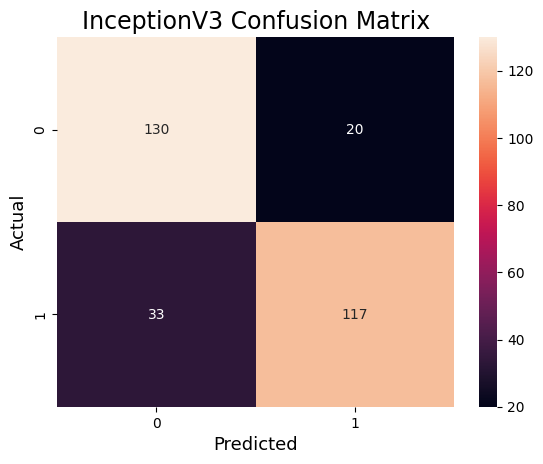

Accuracy (InceptionV3 [Eph:100]) : 0.8233333333333334
              precision    recall  f1-score   support

non_autistic       0.80      0.87      0.83       150
    autistic       0.85      0.78      0.82       150

    accuracy                           0.82       300
   macro avg       0.83      0.82      0.82       300
weighted avg       0.83      0.82      0.82       300



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Y_pred = inception_model.predict(test_data)
#y_pred = np.argmax(Y_pred, axis=1)
#cm = confusion_matrix(test_data.classes, y_pred)
#cm_display = ConfusionMatrixDisplay(cm).plot()

predictions = inception_model.predict(test_data, steps = np.math.ceil(test_data.samples / test_data.batch_size),)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

#cm_display = ConfusionMatrixDisplay(cm).plot()

# Plot the confusion matrix.
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Predicted',fontsize=13)
plt.title('InceptionV3 Confusion Matrix',fontsize=17)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy (InceptionV3 [Eph:100]) :", accuracy)

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Xception


In [ ]:
# Step 1: Connect to GPU runtime (if not already connected)

# Step 2: Import libraries
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 3: Load and preprocess your dataset
# Replace 'path_to_dataset' with the path to your dataset
train_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/train'
validation_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/valid'
test_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/test'

# Specify image dimensions (Xception input size)
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation for training set (optional but recommended)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Preprocess and augment validation/test sets
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 4: Create the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of Xception
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
epochs = 60 #TRY 50 # You can increase the number of epochs based on your dataset and model complexity
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Step 7: Evaluate the model
#test_loss, test_acc = model.evaluate(test_generator)
#print("Test accuracy:", test_acc)


Found 2538 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

predictions = model.predict(test_generator, steps = np.math.ceil(test_generator.samples / test_generator.batch_size),)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

#cm_display = ConfusionMatrixDisplay(cm).plot()

# Plot the confusion matrix.
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual',fontsize=11)
plt.xlabel('Predicted',fontsize=11)
plt.title('Xception Confusion Matrix',fontsize=14)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy (Xception [Eph:100]):", accuracy)

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# MobileNetV2

In [ ]:
# Step 2: Import libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 3: Load and preprocess your dataset
train_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/train'
validation_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/valid'
test_data_dir = '/content/drive/MyDrive/Autism Photos Dataset/test'

# Specify image dimensions (MobileNetV2 input size)
img_width, img_height = 224, 224
batch_size = 32

# Data augmentation for training set (optional but recommended)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Preprocess and augment validation/test sets
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 4: Create the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of MobileNetV2
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
epochs = 80  # You can increase the number of epochs based on your dataset and model complexity
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Step 7: Evaluate the model
#test_loss, test_acc = model.evaluate(test_generator)
#print("Test accuracy:", test_acc)


In [ ]:
# Step 7: Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

10/10 [==============================] - 1s 60ms/step - loss: 1.2966 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


10/10 [==============================] - 1s 66ms/step


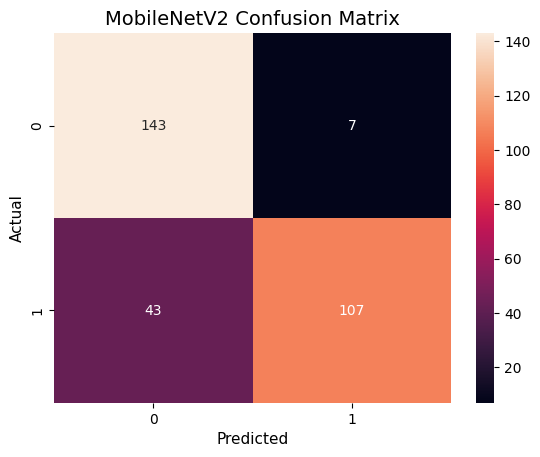

Accuracy (MobileNetV2 [Eph:60]): 0.8333333333333334
              precision    recall  f1-score   support

    autistic       0.77      0.95      0.85       150
non_autistic       0.94      0.71      0.81       150

    accuracy                           0.83       300
   macro avg       0.85      0.83      0.83       300
weighted avg       0.85      0.83      0.83       300



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

predictions = model.predict(test_generator, steps = np.math.ceil(test_generator.samples / test_generator.batch_size),)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

#cm_display = ConfusionMatrixDisplay(cm).plot()

# Plot the confusion matrix.
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual',fontsize=11)
plt.xlabel('Predicted',fontsize=11)
plt.title('MobileNetV2 Confusion Matrix',fontsize=14)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy (MobileNetV2 [Eph:80]):", accuracy)

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)